In [2]:
import gc
import importlib
import pickle
from abc import ABC
from datetime import datetime

import alphalens as al
import numba as nb
import numpy as np
import pandas as pd
import polars as pl
from matplotlib import pyplot as plt

from AlphaEngine.alphabase import Alpha
from AlphaEngine.cs_alphatest import tearsheet
from AlphaEngine.dataloader import DataLoader
from AlphaEngine.operators import numba as op
from AlphaEngine.ts_alphatest import ic

In [22]:
class primitive_momentum(Alpha):
    def formula(self, adjclose_ratio: pd.DataFrame):
        timeperiod = 240
        alpha = op.ts_delta_pct(adjclose_ratio, timeperiod)
        return alpha

In [ ]:
class signal_momentum(Alpha):
    def formula(self, adjclose_ratio: pd.DataFrame):
        timeperiod = 240
        ret = op.ts_delta_pct(adjclose_ratio, 1)
        alpha = op.ts_mean(op.sign(ret), timeperiod)
        return alpha

In [ ]:
class cum_amplitude(Alpha):
    def formula(self, adjopen_ratio: pd.DataFrame, adjclose_ratio: pd.DataFrame):
        timeperiod = 240
        ret = op.div(adjclose_ratio, adjopen_ratio) - 1
        alpha = op.ts_mean(ret, timeperiod)
        return alpha

In [29]:
class gk_trend(Alpha):
    """
    用GK波动率衡量的日内趋势
    """

    def formula(
        self,
        adjopen_diff: pd.DataFrame,
        adjhigh_diff: pd.DataFrame,
        adjlow_diff: pd.DataFrame,
        adjclose_diff: pd.DataFrame,
    ):
        timeperiod = 120
        gk = op.sqrt(
            252
            * op.ts_mean(
                (
                    0.5 * op.pow(op.sub(adjhigh_diff, adjlow_diff), 2)
                    - (2 * np.log(2) - 1) * adjclose_diff
                ),
                timeperiod,
            )
        )
        alpha = op.ts_mean(
            op.mul(op.sign(op.sub(adjclose_diff, adjopen_diff)), gk), timeperiod
        )
        return alpha

In [49]:
class robust_momentum(Alpha):
    def formula(self, adjclose_ratio: pd.DataFrame):
        timeperiod = 240
        ret = op.ts_delta_pct(adjclose_ratio, 1)
        alpha = op.ts_mean(op.cs_rank(ret), timeperiod)
        return alpha


In [50]:
dataloader = DataLoader(
    "D:/southwall/Documents/DataBase/futures/", "date", "2016-01-01", "2022-01-01"
)
factor = robust_momentum(dataloader)
feature = factor.calculate()

In [51]:
label = dataloader.load("adjclose_ratio").pct_change(fill_method=None)

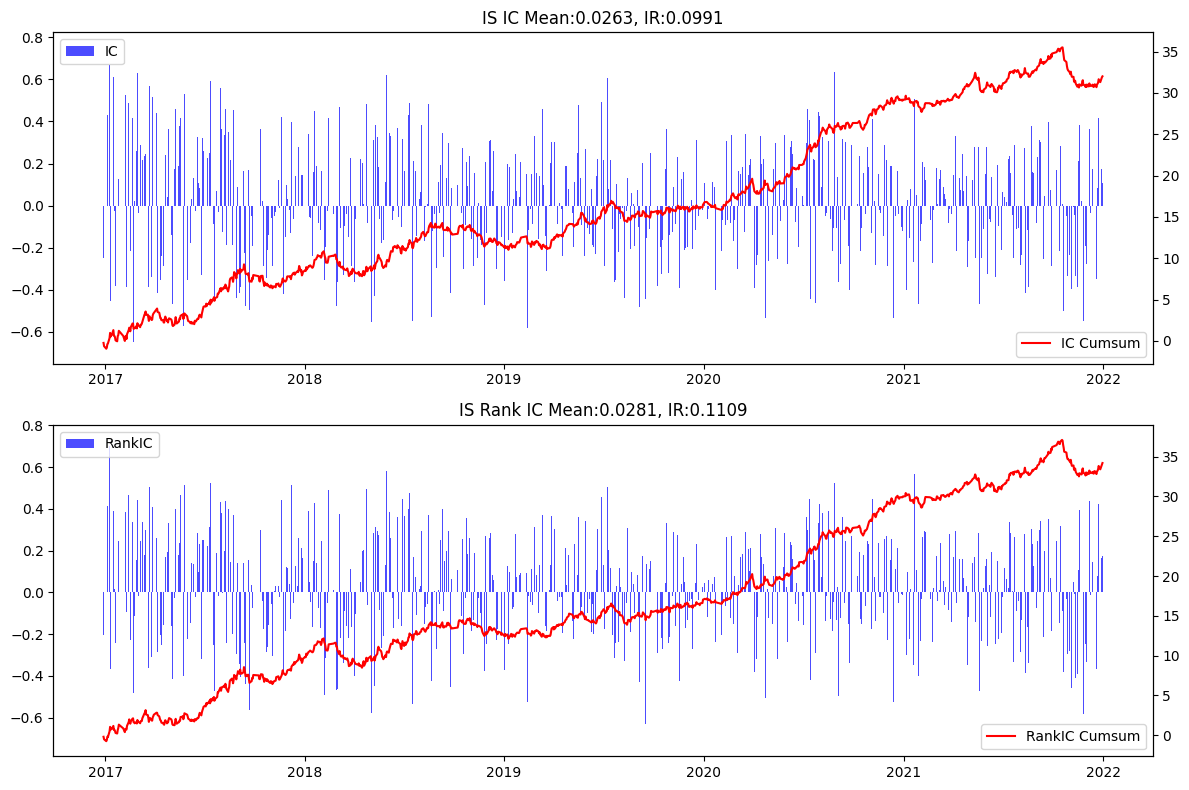

In [52]:
tearsheet(feature, label, forward=1)